In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '../../')

import gc
import pysam

import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import openpyxl


import helpers.train_eval as train_eval    #train and evaluation
import helpers.misc as misc                #miscellaneous functions
from helpers.plots import MetricsHandler, MotifMetrics
from helpers.motifs import motifs

import encoding_utils.sequence_encoders as sequence_encoders
import encoding_utils.sequence_utils as sequence_utils
from models.spec_dss import DSSResNet, DSSResNetEmb, SpecAdd

In [2]:
### Finding all the 

xlsx_file_path = "../../../dataset/1-s2.0-S1097276518303514-mmc4.xlsx"



def find_index(element, my_list):
    return next((index for index, value in enumerate(my_list) if value == element), -1)


# Load the XLSX file
workbook = openpyxl.load_workbook(xlsx_file_path)
sheet = workbook['logo_5mers.prop_in_logo']  # Replace "Sheet1" with the actual sheet name
data = []
for row in sheet.iter_rows(values_only=True):
    data.append(row)

strong_motifs = []
seq_only = []
motif_tup = []
r1_val = []
protein_name = []
iteri =0
top_motifs = []
# Print the data

for i,row in enumerate(data):
    if i == 0:
        continue
    if i == 1:
        for j in range(0,int(len(row)/2)):
            protein_name.append(row[(j*2)])
    if i > 1:        
        for j in range(0,int(len(row)/2)):
            mot = row[(j*2)]
            r1 = row[(j*2)+1]
            if mot not in strong_motifs and mot!=None:
                strong_motifs.append(mot)
                seq_only.append(mot)
                motif_tup.append((protein_name[j],mot,iteri))
                iteri +=1
                r1_val.append(r1)
            if i==2:
                top_motifs.append((protein_name[j],mot,iteri))
            elif mot in strong_motifs: 
                ind = find_index(mot,strong_motifs)
                if r1_val[ind] < r1 :
                    r1_val[ind] = r1


print (motif_tup)
print (len(protein_name))
print (len(strong_motifs))

[('A1CF', 'AATTA', 0), ('BOLL', 'TTTTT', 1), ('CELF1', 'TATGT', 2), ('CNOT4', 'ACACA', 3), ('DAZ3', 'AGTTA', 4), ('DAZAP1', 'ATATA', 5), ('EIF4G2', 'GTTGC', 6), ('ESRP1', 'GGGGG', 7), ('FUBP3', 'TATAT', 8), ('HNRNPA0', 'TATAG', 9), ('HNRNPD', 'TATTA', 10), ('HNRNPDL', 'TAATT', 11), ('HNRNPK', 'GCCCA', 12), ('KHDRBS2', 'ATAAA', 13), ('KHSRP', 'TGTAT', 14), ('MBNL1', 'CGCTT', 15), ('MSI1', 'TAGTT', 16), ('NOVA1', 'TTCAT', 17), ('NUPL2', 'AAAAA', 18), ('PCBP1', 'GCCCC', 19), ('PCBP2', 'CCCCC', 20), ('PCBP4', 'ATCCC', 21), ('PRR3', 'ATAAG', 22), ('PTBP3', 'TTTCT', 23), ('RBFOX2', 'GCATG', 24), ('RBM22', 'ACCGG', 25), ('RBM24', 'GTGTG', 26), ('RBM4', 'GCGCG', 27), ('RBM41', 'TACTT', 28), ('RBM45', 'ACGCA', 29), ('RBM47', 'AATCA', 30), ('RBM6', 'CGTCC', 31), ('RC3H1', 'ATATT', 32), ('SF1', 'TAACA', 33), ('SFPQ', 'TGTAA', 34), ('SNRPA', 'TGCAC', 35), ('SRSF10', 'AGCAG', 36), ('SRSF11', 'AGGGG', 37), ('SRSF8', 'GCAGC', 38), ('SRSF9', 'AGGAG', 39), ('TARDBP', 'GTATG', 40), ('TRA2A', 'GAAGA', 41

In [3]:
from helpers.motifs import MotifHandler

new_motifs = MotifHandler(motif_tup)

In [4]:
class SeqDataset(Dataset):
    
    def __init__(self, fasta_fa, seq_df, transform, motifs):
        
        self.fasta = pysam.FastaFile(fasta_fa)
        
        self.val_fraction = 0.1 
        N_train = int(len(seq_df) * (1-self.val_fraction))
        self.start_index = N_train 
        self.seq_df = seq_df
        self.transform = transform

        self.motifs = motifs
        
    def __len__(self):
        
        return len(self.seq_df[self.start_index:])
    
    def __getitem__(self, idx):
        
        seq = self.fasta.fetch(self.seq_df.iloc[self.start_index + idx].seq_name).upper()
        #print(seq)
                
        species_label = self.seq_df.iloc[self.start_index + idx].species_label
        #print(species_label)
        # x_batch, y_masked_batch, y_batch, mask_batch, motif_mask_batch 
        masked_sequence, target_labels_masked, target_labels, mask, motif_mask_batch = self.transform(seq, motifs = self.motifs)
        
        masked_sequence = (masked_sequence, species_label)
        return masked_sequence, target_labels_masked, target_labels, motif_mask_batch
    
    def close(self):
        self.fasta.close()

In [5]:
fasta_fa = "../../../dataset/data_homo/Homo_sapiens_3prime_UTR.fa"
species_list = "../../240_species.txt"
species_agnostic = False

seq_df = pd.read_csv(fasta_fa + '.fai', header=None, sep='\t', usecols=[0], names=['seq_name'])
seq_df['species_name'] = seq_df.seq_name.apply(lambda x:x.split(':')[1])
species_encoding = pd.read_csv(species_list, header=None).squeeze().to_dict()

if not species_agnostic:
    species_encoding = {species:idx for idx,species in species_encoding.items()}
else:
    species_encoding = {species:0 for _,species in species_encoding.items()}

species_encoding['Homo_sapiens'] = species_encoding['Pan_troglodytes']
seq_df['species_label'] = seq_df.species_name.map(species_encoding)

seq_df

,seq_name,species_name,species_label
0,ENST00000641515.2_utr3_2_0_chr1_70009_f:Homo_s...,Homo_sapiens,181
1,ENST00000616016.5_utr3_13_0_chr1_944154_f:Homo...,Homo_sapiens,181
2,ENST00000327044.7_utr3_18_0_chr1_944203_r:Homo...,Homo_sapiens,181
3,ENST00000338591.8_utr3_11_0_chr1_965192_f:Homo...,Homo_sapiens,181
4,ENST00000379410.8_utr3_15_0_chr1_974576_f:Homo...,Homo_sapiens,181
...,...,...,...
18129,ENST00000303766.12_utr3_11_0_chrY_22168542_r:H...,Homo_sapiens,181
18130,ENST00000250831.6_utr3_11_0_chrY_22417604_f:Ho...,Homo_sapiens,181
18131,ENST00000303728.5_utr3_4_0_chrY_22514071_f:Hom...,Homo_sapiens,181
18132,ENST00000382407.1_utr3_0_0_chrY_24045793_r:Hom...,Homo_sapiens,181


In [7]:
kseq_len = 5000
total_len = 5000

seq_transform = sequence_encoders.RollingMasker()      
test_dataset = SeqDataset(fasta_fa, seq_df, transform = seq_transform, motifs=new_motifs.dict)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 1, collate_fn = None, shuffle = False)
len(test_dataset)

1814

In [8]:
gc.collect()
torch.cuda.empty_cache()
# test wether cuda is available - if cpu_bool is set to True, cuda is not used

# TODO checkout why gpu isn't working
cpu_bool = True
device = torch.device("cuda" if torch.cuda.is_available() and not cpu_bool else "cpu")

d_model = 128
n_layers = 4
dropout = 0.
learn_rate = 1e-4
weight_decay = 0.
output_dir = "./test/"
get_embeddings = True
save_at = None

species_encoder = SpecAdd(embed = True, encoder = 'label', d_model = 128)

model = DSSResNetEmb(d_input = 5, d_output = 5, d_model = d_model, n_layers = n_layers, 
                     dropout = dropout, embed_before = True, species_encoder = species_encoder)

model = model.to(device) 

model_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(model_params, lr = learn_rate, weight_decay = weight_decay)

last_epoch = 0

In [9]:
if not species_agnostic:
    model_weight = "../../../dataset/data_homo/MLM_mammals_species_aware_5000_weights"
else :
    model_weight = "../../../dataset/data_homo/MLM_mammals_species_agnostic_5000_weights"
# load model but avoid torch._C._cuda_getDeviceCount() > 0 failed error
model.load_state_dict(torch.load(model_weight, map_location=device))

<All keys matched successfully>

In [10]:

predictions_dir = os.path.join(output_dir, 'predictions') #dir to save predictions
weights_dir = os.path.join(output_dir, 'weights') #dir to save model weights at save_at epochs
if save_at:
    os.makedirs(weights_dir, exist_ok = True)

def metrics_to_str(metrics):
    loss, total_acc, masked_acc = metrics
    return f'loss: {loss:.4}, total acc: {total_acc:.3f}, masked acc: {masked_acc:.3f}'


In [11]:

from helpers.metrics import MaskedAccuracy
def model_eval_check(model, optimizer, dataloader, device, get_embeddings = False, silent=False):
    criterion = torch.nn.CrossEntropyLoss(reduction = "mean")

    metric = MaskedAccuracy()
    motif_metric = MaskedAccuracy()

    model.eval() #model to train mode

    if not silent:
        tot_itr = len(dataloader.dataset)//dataloader.batch_size #total train iterations
        pbar = tqdm(total = tot_itr, ncols=700) #progress bar

    avg_loss, masked_acc, total_acc = 0., 0., 0.
    
    all_embeddings = []
    outputs = []
    with torch.no_grad():
        #               x_batch, y_masked_batch, y_batch, mask_batch, motif_mask_batch
        for itr_idx, (((masked_sequence, species_label), targets_masked, targets, motif_mask)) in enumerate(dataloader):
            
            if get_embeddings:
                #batches are generated by transformation in the dataset,
                #so remove extra batch dimension added by dataloader
                masked_sequence, targets_masked, targets = masked_sequence[0], targets_masked[0], targets[0]
                species_label = species_label.tile((len(masked_sequence),))
            
            masked_sequence = masked_sequence.to(device)
            targets_masked = targets_masked.to(device)

            motif_targets=targets.detach().clone()
            motif_targets[motif_mask.squeeze()== 0] = -100.0
            print(f"{itr_idx}: {motif_targets.shape}")
            motif_targets[targets_masked == -100] = -100.0
            targets = targets.to(device)
            species_label = torch.tensor(species_label).long().to(device)
            
            logits, embeddings = model(masked_sequence, species_label)

            loss = criterion(logits, targets_masked)

            avg_loss += loss.item()
                
            preds = torch.argmax(logits, dim=1)


            test_acc_motif = motif_metric(preds, motif_targets)
            masked_acc += metric(preds, targets_masked).detach() # compute only on masked nucleotides
            total_acc += metric(preds, targets).detach()
            #print(masked_acc/(itr_idx+1))
                
            if get_embeddings:
                # only get embeddings of the masked nucleotide
                sequence_embedding = embeddings["seq_embedding"]
                sequence_embedding = sequence_embedding.transpose(-1,-2)[targets_masked!=-100]
                # shape # B, L, dim  to L,dim, left with only masked nucleotide embeddings
                # average over sequence 
                #print(sequence_embedding.shape)
                sequence_embedding = sequence_embedding.mean(dim=0) # if we mask
                #sequence_embedding = sequence_embedding[0].mean(dim=-1) # no mask

                sequence_embedding = sequence_embedding.detach().cpu().numpy()
                all_embeddings.append(sequence_embedding)
                
            if not silent:
                pbar.update(1)
                pbar.set_description(f"acc: {total_acc/(itr_idx+1):.2}, masked acc: {masked_acc/(itr_idx+1):.2}, motif acc {test_acc_motif/(itr_idx+1):.2} loss: {avg_loss/(itr_idx+1):.4}")
            outputs.append({"loss": loss, "preds": preds, "logits": logits, "targets": targets_masked, "motifs": motif_mask})
    if not silent:
        del pbar
    return outputs


In [12]:
import time
start = time.time()
outputs = model_eval_check(model, optimizer, test_dataloader, device, 
                                                        get_embeddings = get_embeddings, silent = True)
end = time.time()
print("Time taken in mins: ", (end-start)/60)

0: torch.Size([30, 4956])


/tmp/ipykernel_225969/3636492396.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  species_label = torch.tensor(species_label).long().to(device)
/home/anas/Desktop/code/ML4RG-2023-project/our_code/results/entropy/../../models/dss.py:335: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680527322149/work/aten/src/ATen/native/Copy.cpp:276.)
  return einsum('chn,hnl->chl', W, S).float(), state                   # [C H L]
/home/anas/anaconda3/envs/ML4RG-mlm/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a fu

1: torch.Size([30, 1214])
2: torch.Size([30, 892])
3: torch.Size([30, 511])
4: torch.Size([30, 504])
5: torch.Size([30, 555])
6: torch.Size([30, 2448])
7: torch.Size([30, 2522])
8: torch.Size([30, 6014])
9: torch.Size([30, 2441])
10: torch.Size([30, 891])
11: torch.Size([30, 2879])
12: torch.Size([30, 1550])
13: torch.Size([30, 218])
14: torch.Size([30, 154])
15: torch.Size([30, 1021])
16: torch.Size([30, 1276])
17: torch.Size([30, 466])
18: torch.Size([30, 5654])
19: torch.Size([30, 777])
20: torch.Size([30, 2377])
21: torch.Size([30, 5823])
22: torch.Size([30, 426])
23: torch.Size([30, 3850])
24: torch.Size([30, 1714])
25: torch.Size([30, 594])
26: torch.Size([30, 1518])
27: torch.Size([30, 1907])
28: torch.Size([30, 1101])
29: torch.Size([30, 1656])
30: torch.Size([30, 258])
31: torch.Size([30, 1986])
32: torch.Size([30, 2798])
33: torch.Size([30, 126])
34: torch.Size([30, 2245])
35: torch.Size([30, 1003])
36: torch.Size([30, 7883])
37: torch.Size([30, 1511])
38: torch.Size([30, 116

302: torch.Size([30, 186])
303: torch.Size([30, 119])
304: torch.Size([30, 339])
305: torch.Size([30, 390])
306: torch.Size([30, 1970])
307: torch.Size([30, 2620])
308: torch.Size([30, 120])
309: torch.Size([30, 100])
310: torch.Size([30, 257])
311: torch.Size([30, 168])
312: torch.Size([30, 87])
313: torch.Size([30, 124])
314: torch.Size([30, 188])
315: torch.Size([30, 368])
316: torch.Size([30, 797])
317: torch.Size([30, 310])
318: torch.Size([30, 813])
319: torch.Size([30, 826])
320: torch.Size([30, 218])
321: torch.Size([30, 172])
322: torch.Size([30, 49])
323: torch.Size([30, 143])
324: torch.Size([30, 3694])
325: torch.Size([30, 87])
326: torch.Size([30, 1609])
327: torch.Size([30, 1243])
328: torch.Size([30, 735])
329: torch.Size([30, 1042])
330: torch.Size([30, 35])
331: torch.Size([30, 1689])
332: torch.Size([30, 604])
333: torch.Size([30, 488])
334: torch.Size([30, 4560])
335: torch.Size([30, 380])
336: torch.Size([30, 1873])
337: torch.Size([30, 294])
338: torch.Size([30, 56

601: torch.Size([30, 1671])
602: torch.Size([30, 1423])
603: torch.Size([30, 1497])
604: torch.Size([30, 944])
605: torch.Size([30, 1380])
606: torch.Size([30, 1270])
607: torch.Size([30, 362])
608: torch.Size([30, 78])
609: torch.Size([30, 183])
610: torch.Size([30, 1021])
611: torch.Size([30, 327])
612: torch.Size([30, 3417])
613: torch.Size([30, 426])
614: torch.Size([30, 2818])
615: torch.Size([30, 7676])
616: torch.Size([30, 278])
617: torch.Size([30, 839])
618: torch.Size([30, 1469])
619: torch.Size([30, 476])
620: torch.Size([30, 3396])
621: torch.Size([30, 2949])
622: torch.Size([30, 525])
623: torch.Size([30, 301])
624: torch.Size([30, 1061])
625: torch.Size([30, 1318])
626: torch.Size([30, 600])
627: torch.Size([30, 478])
628: torch.Size([30, 2352])
629: torch.Size([30, 2772])
630: torch.Size([30, 1083])
631: torch.Size([30, 1000])
632: torch.Size([30, 7380])
633: torch.Size([30, 2649])
634: torch.Size([30, 3791])
635: torch.Size([30, 2046])
636: torch.Size([30, 644])
637: to

898: torch.Size([30, 5043])
899: torch.Size([30, 430])
900: torch.Size([30, 253])
901: torch.Size([30, 1330])
902: torch.Size([30, 1314])
903: torch.Size([30, 1118])
904: torch.Size([30, 1992])
905: torch.Size([30, 721])
906: torch.Size([30, 1624])
907: torch.Size([30, 2686])
908: torch.Size([30, 2822])
909: torch.Size([30, 1176])
910: torch.Size([30, 2744])
911: torch.Size([30, 974])
912: torch.Size([30, 4319])
913: torch.Size([30, 693])
914: torch.Size([30, 1239])
915: torch.Size([30, 1613])
916: torch.Size([30, 2722])
917: torch.Size([30, 426])
918: torch.Size([30, 2415])
919: torch.Size([30, 2883])
920: torch.Size([30, 367])
921: torch.Size([30, 809])
922: torch.Size([30, 730])
923: torch.Size([30, 1869])
924: torch.Size([30, 6008])
925: torch.Size([30, 110])
926: torch.Size([30, 1419])
927: torch.Size([30, 4886])
928: torch.Size([30, 637])
929: torch.Size([30, 523])
930: torch.Size([30, 97])
931: torch.Size([30, 865])
932: torch.Size([30, 629])
933: torch.Size([30, 3093])
934: tor

1190: torch.Size([30, 1627])
1191: torch.Size([30, 2118])
1192: torch.Size([30, 7701])
1193: torch.Size([30, 2589])
1194: torch.Size([30, 2165])
1195: torch.Size([30, 366])
1196: torch.Size([30, 101])
1197: torch.Size([30, 214])
1198: torch.Size([30, 199])
1199: torch.Size([30, 1229])
1200: torch.Size([30, 398])
1201: torch.Size([30, 904])
1202: torch.Size([30, 2252])
1203: torch.Size([30, 451])
1204: torch.Size([30, 963])
1205: torch.Size([30, 98])
1206: torch.Size([30, 993])
1207: torch.Size([30, 1308])
1208: torch.Size([30, 46])
1209: torch.Size([30, 8995])
1210: torch.Size([30, 1316])
1211: torch.Size([30, 88])
1212: torch.Size([30, 952])
1213: torch.Size([30, 91])
1214: torch.Size([30, 389])
1215: torch.Size([30, 332])
1216: torch.Size([30, 259])
1217: torch.Size([30, 1634])
1218: torch.Size([30, 3837])
1219: torch.Size([30, 265])
1220: torch.Size([30, 1446])
1221: torch.Size([30, 213])
1222: torch.Size([30, 147])
1223: torch.Size([30, 364])
1224: torch.Size([30, 44])
1225: torch.

1481: torch.Size([30, 2852])
1482: torch.Size([30, 400])
1483: torch.Size([30, 5120])
1484: torch.Size([30, 519])
1485: torch.Size([30, 6124])
1486: torch.Size([30, 190])
1487: torch.Size([30, 35])
1488: torch.Size([30, 168])
1489: torch.Size([30, 3010])
1490: torch.Size([30, 1065])
1491: torch.Size([30, 1433])
1492: torch.Size([30, 1181])
1493: torch.Size([30, 1303])
1494: torch.Size([30, 2185])
1495: torch.Size([30, 686])
1496: torch.Size([30, 1940])
1497: torch.Size([30, 741])
1498: torch.Size([30, 5642])
1499: torch.Size([30, 949])
1500: torch.Size([30, 1878])
1501: torch.Size([30, 994])
1502: torch.Size([30, 1298])
1503: torch.Size([30, 1147])
1504: torch.Size([30, 4564])
1505: torch.Size([30, 216])
1506: torch.Size([30, 1803])
1507: torch.Size([30, 767])
1508: torch.Size([30, 959])
1509: torch.Size([30, 1386])
1510: torch.Size([30, 1167])
1511: torch.Size([30, 2573])
1512: torch.Size([30, 2010])
1513: torch.Size([30, 892])
1514: torch.Size([30, 2694])
1515: torch.Size([30, 4337])

1770: torch.Size([30, 1692])
1771: torch.Size([30, 165])
1772: torch.Size([30, 571])
1773: torch.Size([30, 571])
1774: torch.Size([30, 165])
1775: torch.Size([30, 2524])
1776: torch.Size([30, 7721])
1777: torch.Size([30, 134])
1778: torch.Size([30, 374])
1779: torch.Size([30, 2513])
1780: torch.Size([30, 239])
1781: torch.Size([30, 4282])
1782: torch.Size([30, 193])
1783: torch.Size([30, 155])
1784: torch.Size([30, 191])
1785: torch.Size([30, 188])
1786: torch.Size([30, 188])
1787: torch.Size([30, 188])
1788: torch.Size([30, 188])
1789: torch.Size([30, 188])
1790: torch.Size([30, 188])
1791: torch.Size([30, 1423])
1792: torch.Size([30, 2356])
1793: torch.Size([30, 1471])
1794: torch.Size([30, 765])
1795: torch.Size([30, 99])
1796: torch.Size([30, 99])
1797: torch.Size([30, 4392])
1798: torch.Size([30, 7])
1799: torch.Size([30, 6])
1800: torch.Size([30, 121])
1801: torch.Size([30, 121])
1802: torch.Size([30, 2130])
1803: torch.Size([30, 808])
1804: torch.Size([30, 278])
1805: torch.Size

In [13]:
import pickle
outputs_file = "../../../our_code/results/species_aware/outputs.pickle"
with open(outputs_file, "wb") as f:
    pickle.dump(outputs, f)

In [14]:
motif_metrics = MotifMetrics(outputs=outputs, plots_dir="../../../our_code/results/species_aware/", motif_dict=new_motifs.dict, save=True)

No nan entries in preds


KeyboardInterrupt: 

In [2]:
import seaborn as sns
#sns.set_theme(context="poster")
sns.set_theme()
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
#
#sns.set_context("poster", 
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})
#sns.set_style("ticks")

In [8]:
model_paths = ["../../../our_code/results/species_aware/"]
model_names = ["Species-aware"]
test_path = "../../../dataset/data_homo/Homo_sapiens_3prime_UTR.fa"
print(test_path)
scer_mh = MetricsHandler(model_paths, model_names, test_path, 
                         motifs=new_motifs, seq_col="3UTR",
                         existing_probas=None,
                         n_random_kmers=6290,
                         optional_config=None)

../../../dataset/data_homo/Homo_sapiens_3prime_UTR.fa
Adding models to df
Species-aware
3036871
Searching for motifs
True
A1CF AATTA
A1CF AATTA
True
BOLL TTTTT
BOLL TTTTT
True
CELF1 TATGT
CELF1 TATGT
True
CNOT4 ACACA
CNOT4 ACACA
True
DAZ3 AGTTA
DAZ3 AGTTA
True
DAZAP1 ATATA
DAZAP1 ATATA
True
EIF4G2 GTTGC
EIF4G2 GTTGC
True
ESRP1 GGGGG
ESRP1 GGGGG
True
FUBP3 TATAT
FUBP3 TATAT
True
HNRNPA0 TATAG
HNRNPA0 TATAG
True
HNRNPD TATTA
HNRNPD TATTA
True
HNRNPDL TAATT
HNRNPDL TAATT
True
HNRNPK GCCCA
HNRNPK GCCCA
True
KHDRBS2 ATAAA
KHDRBS2 ATAAA
True
KHSRP TGTAT
KHSRP TGTAT
True
MBNL1 CGCTT
MBNL1 CGCTT
True
MSI1 TAGTT
MSI1 TAGTT
True
NOVA1 TTCAT
NOVA1 TTCAT
True
NUPL2 AAAAA
NUPL2 AAAAA
True
PCBP1 GCCCC
PCBP1 GCCCC
True
PCBP2 CCCCC
PCBP2 CCCCC
True
PCBP4 ATCCC
PCBP4 ATCCC
True
PRR3 ATAAG
PRR3 ATAAG
True
PTBP3 TTTCT
PTBP3 TTTCT
True
RBFOX2 GCATG
RBFOX2 GCATG
True
RBM22 ACCGG
RBM22 ACCGG
True
RBM24 GTGTG
RBM24 GTGTG
True
RBM4 GCGCG
RBM4 GCGCG
True
RBM41 TACTT
RBM41 TACTT
True
RBM45 ACGCA
RBM45 ACGCA
Tru

False
DAZ3 ACGTT
DAZ3 AGTTA
False
NOVA1 ATCAC
NOVA1 TTCAT
1032750
Get non-motif kmer instances
Creating large DataFrame


In [7]:
whole_seq = scer_mh.debug_seq
print (whole_seq)
def return_alpha(range_tup):
    alphabet = "ACGTN"
    total_alph = ""
    for i in range(range_tup[0],range_tup[1]):
        total_alph = total_alph + alphabet[whole_seq[i]]
    return total_alph

#scer_mh.motif_df['alphabet_seq'] = scer_mh.motif_df['motif_range'].apply(return_alpha)
#scer_mh.motif_df

tensor([1, 1, 1,  ..., 0, 0, 0])


In [8]:
import math
from collections import Counter

def shannon_entropy(sequence):
    # Count the frequency of each letter
    letter_counts = Counter(sequence)
    
    # Calculate the total number of letters
    total_letters = len(sequence)
    
    # Calculate the probability and entropy for each letter
    entropy = 0
    for count in letter_counts.values():
        probability = count / total_letters
        entropy -= probability * math.log2(probability)
    
    return entropy

#scer_mh.motif_df['shanon_entropy'] = scer_mh.motif_df['alphabet_seq'].apply(shannon_entropy)
#scer_mh.motif_df

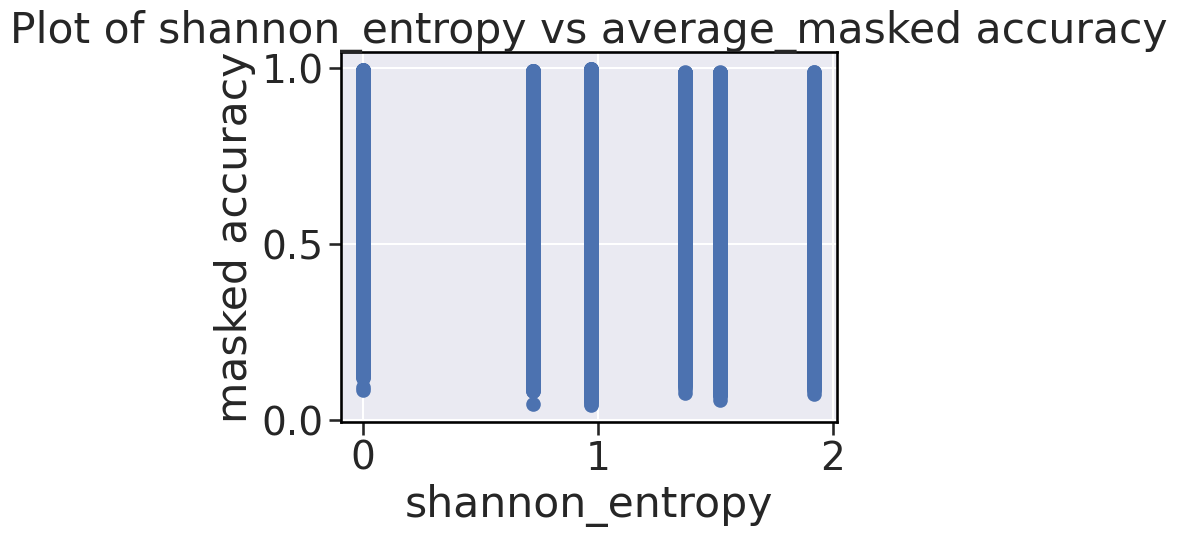

In [21]:
import matplotlib.pyplot as plt

# Plot values from 'X' and 'Y' columns
plt.scatter(scer_mh.motif_df['shanon_entropy'], scer_mh.motif_df['Species-aware_avg_target_probas'])

# Set plot title and axis labels
plt.title('Plot of shannon_entropy vs average_masked accuracy')
plt.xlabel('shannon_entropy')
plt.ylabel('masked accuracy')

# Show the plot
plt.show()
#add violinn plot and box plot. plt.box_plot

In [6]:
top_motifs_hand = MotifHandler(top_motifs)
model_paths = ["../../../our_code/results/species_aware/"]
model_names = ["Species-aware"]
test_path = "../../../dataset/data_homo/Homo_sapiens_3prime_UTR.fa"
print(test_path)
scer_mh = MetricsHandler(model_paths, model_names, test_path, 
                         motifs=top_motifs_hand, seq_col="3UTR",
                         existing_probas=None,
                         n_random_kmers=6290,
                         optional_config=None)

../../../dataset/data_homo/Homo_sapiens_3prime_UTR.fa
Adding models to df
Species-aware
3036871
Searching for motifs
True
A1CF AATTA
A1CF AATTA
True
BOLL TTTTT
BOLL TTTTT
True
CELF1 TATGT
CELF1 TATGT
True
CNOT4 ACACA
CNOT4 ACACA
True
CPEB1 TTTTT
CPEB1 TTTTT
True
DAZ3 AGTTA
DAZ3 AGTTA
True
DAZAP1 ATATA
DAZAP1 ATATA
True
EIF4G2 GTTGC
EIF4G2 GTTGC
True
ELAVL4 TTTTT
ELAVL4 TTTTT
True
ESRP1 GGGGG
ESRP1 GGGGG
True
EWSR1 GGGGG
EWSR1 GGGGG
True
FUBP1 TTTTT
FUBP1 TTTTT
True
FUBP3 TATAT
FUBP3 TATAT
True
FUS GGGGG
FUS GGGGG
True
HNRNPA0 TATAG
HNRNPA0 TATAG
True
HNRNPA2B1 GGGGG
HNRNPA2B1 GGGGG
True
HNRNPC TTTTT
HNRNPC TTTTT
True
HNRNPCL1 TTTTT
HNRNPCL1 TTTTT
True
HNRNPD TATTA
HNRNPD TATTA
True
HNRNPDL TAATT
HNRNPDL TAATT
True
HNRNPF GGGGG
HNRNPF GGGGG
True
HNRNPH2 GGGGG
HNRNPH2 GGGGG
True
HNRNPK GCCCA
HNRNPK GCCCA
True
HNRNPL ACACA
HNRNPL ACACA
True
IGF2BP1 ACACA
IGF2BP1 ACACA
True
IGF2BP2 ACACA
IGF2BP2 ACACA
True
ILF2 GGGGG
ILF2 GGGGG
True
KHDRBS2 ATAAA
KHDRBS2 ATAAA
True
KHDRBS3 ATAAA
KHDRBS3 AT

In [9]:
scer_mh.motif_df['alphabet_seq'] = scer_mh.motif_df['motif_range'].apply(return_alpha)
scer_mh.motif_df['shanon_entropy'] = scer_mh.motif_df['alphabet_seq'].apply(shannon_entropy)
scer_mh.motif_df

,motif_range,motif,Species-aware_preds,Species-aware_ce,Species-aware_ll,Species-aware_target_probas,Species-aware_cross_entropy,Species-aware_avg_target_probas,alphabet_seq,shanon_entropy
0,"(2029318, 2029323)",non_motif,"[tensor(1), tensor(2), tensor(0), tensor(0), t...","[tensor(0.7728), tensor(0.0734), tensor(0.0090...","[tensor(-0.7728), tensor(-0.0734), tensor(-0.0...","[tensor(0.4617), tensor(0.9292), tensor(0.9910...",0.188757,0.859070,TGAAC,1.921928
1,"(1635230, 1635235)",non_motif,"[tensor(2), tensor(3), tensor(2), tensor(1), t...","[tensor(0.9910), tensor(0.9226), tensor(1.0884...","[tensor(-0.9910), tensor(-0.9226), tensor(-1.0...","[tensor(0.3712), tensor(0.3975), tensor(0.3368...",1.208822,0.312048,GTGAC,1.921928
2,"(1949056, 1949061)",non_motif,"[tensor(3), tensor(0), tensor(0), tensor(3), t...","[tensor(1.6804), tensor(1.1888), tensor(1.8605...","[tensor(-1.6804), tensor(-1.1888), tensor(-1.8...","[tensor(0.1863), tensor(0.3046), tensor(0.1556...",1.355883,0.278815,AACTG,1.921928
3,"(2811217, 2811222)",non_motif,"[tensor(3), tensor(0), tensor(3), tensor(3), t...","[tensor(0.9633), tensor(1.4188), tensor(1.4019...","[tensor(-0.9633), tensor(-1.4188), tensor(-1.4...","[tensor(0.3816), tensor(0.2420), tensor(0.2461...",1.501426,0.250031,TTAAG,1.521928
4,"(844469, 844474)",non_motif,"[tensor(0), tensor(1), tensor(0), tensor(0), t...","[tensor(0.8922), tensor(1.2022), tensor(1.5604...","[tensor(-0.8922), tensor(-1.2022), tensor(-1.5...","[tensor(0.4098), tensor(0.3005), tensor(0.2101...",1.054750,0.364203,GGCAG,1.370951
...,...,...,...,...,...,...,...,...,...,...
407014,"(3026255, 3026260)",ZNF326,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.2927), tensor(1.7819), tensor(1.1943...","[tensor(-1.2927), tensor(-1.7819), tensor(-1.1...","[tensor(0.2745), tensor(0.1683), tensor(0.3029...",1.361546,0.263226,GGATG,1.370951
407015,"(3028680, 3028685)",ZNF326,"[tensor(3), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5785), tensor(1.6475), tensor(1.1804...","[tensor(-1.5785), tensor(-1.6475), tensor(-1.1...","[tensor(0.2063), tensor(0.1925), tensor(0.3072...",1.311867,0.277663,GGATG,1.370951
407016,"(3031233, 3031238)",ZNF326,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5197), tensor(1.7734), tensor(1.1764...","[tensor(-1.5197), tensor(-1.7734), tensor(-1.1...","[tensor(0.2188), tensor(0.1697), tensor(0.3084...",1.454666,0.241268,GGATG,1.370951
407017,"(3032415, 3032420)",ZNF326,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.7160), tensor(1.8360), tensor(1.0688...","[tensor(-1.7160), tensor(-1.8360), tensor(-1.0...","[tensor(0.1798), tensor(0.1594), tensor(0.3434...",1.499040,0.232042,GGATG,1.370951


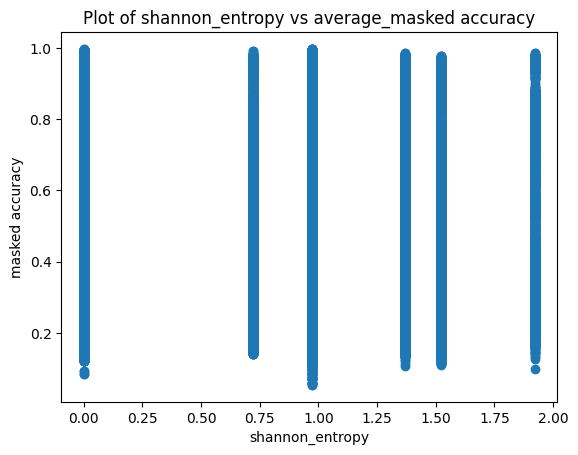

In [10]:
import matplotlib.pyplot as plt

# Plot values from 'X' and 'Y' columns
plt.scatter(scer_mh.motif_df['shanon_entropy'], scer_mh.motif_df['Species-aware_avg_target_probas'])

# Set plot title and axis labels
plt.title('Plot of shannon_entropy vs average_masked accuracy')
plt.xlabel('shannon_entropy')
plt.ylabel('masked accuracy')

# Show the plot
plt.show()